In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import LinearRegression

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

In [2]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [3]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'
RESULT_DATASET_EXT_PATH = 'DSiyayev_predictions.csv'

In [4]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)

In [5]:
test_df = pd.read_csv(TEST_DATASET_PATH)

In [6]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [7]:
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [8]:
train_df.shape

(10000, 20)

In [9]:
test_df.shape

(5000, 19)

In [10]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [11]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

**Cмотрим целевую переменную**

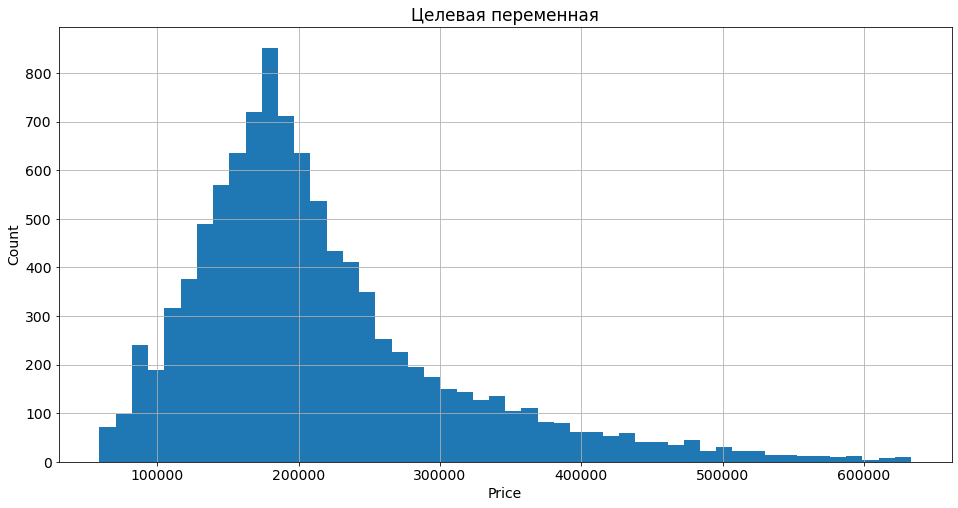

In [12]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=50)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Целевая переменная')
plt.show()

**Обработка пропусков**

In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  object 
 1   DistrictId     10000 non-null  object 
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [14]:
train_df.loc[train_df['LifeSquare'].isnull(),'LifeSquare'] = train_df['LifeSquare'].median()
train_df.loc[train_df['Healthcare_1'].isnull(),'Healthcare_1'] = train_df['Healthcare_1'].median()

**Подготовливаем данные**

In [15]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [16]:
train_df.loc[train_df['Rooms'].isin([0, 10, 19]), 'Rooms'] = train_df['Rooms'].median()

In [17]:
train_df = train_df[train_df['Square'].isnull() |
                    (train_df['Square'] < train_df['Square'].quantile(.99)) &
                    (train_df['Square'] > train_df['Square'].quantile(.01))]

train_df = train_df[train_df['LifeSquare'].isnull() |
                    (train_df['LifeSquare'] < train_df['LifeSquare'].quantile(.99)) &
                    (train_df['LifeSquare'] > train_df['LifeSquare'].quantile(.01))]

train_df = train_df[train_df['KitchenSquare'].isnull() |
                    (train_df['KitchenSquare'] < train_df['KitchenSquare'].quantile(.99)) &
                    (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.01))]

In [18]:
train_df.loc[train_df['LifeSquare'] < 10, 'LifeSquare'] = 10
train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [19]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [20]:
floor_outliers = train_df[train_df['Floor'] > train_df['HouseFloor']].index

train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))

In [21]:
train_df['HouseYear'].sort_values(ascending=False)

1497    20052011
4189        4968
3859        2020
790         2020
8253        2020
          ...   
5053        1917
8144        1917
1380        1917
7611        1916
910         1914
Name: HouseYear, Length: 8848, dtype: int64

In [22]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

In [23]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,8848.000000,8848.000000,8848.000000,8848.000000,8848.000000,8848.000000,8848.000000,8848.000000,8848.000000,8848.000000,8848.000000,8848.000000,8848.000000,8848.000000,8848.000000
mean,1.883476,54.734456,34.473306,6.599797,7.355674,12.841659,1984.500452,0.119672,26.106126,5636.478865,8.366297,1039.409245,1.394100,4.436144,214855.187974
std,0.796799,16.164725,12.604223,2.793279,4.972351,6.332674,18.336585,0.119673,17.267244,3977.972421,24.173064,770.862595,1.491651,4.825050,89603.516533
min,1.000000,29.719934,10.000000,3.000000,1.000000,1.000000,1914.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.627579,24.709710,3.000000,3.000000,9.000000,1972.000000,0.017647,11.000000,2370.000000,0.000000,810.000000,0.000000,1.000000,156895.897557
50%,2.000000,51.622306,32.781260,6.000000,6.000000,14.000000,1977.000000,0.075779,25.000000,5562.000000,2.000000,900.000000,1.000000,3.000000,194169.421353
75%,2.000000,64.624549,41.052147,9.000000,10.000000,17.000000,2000.000000,0.194812,36.000000,7614.000000,5.000000,1036.000000,3.000000,6.000000,250272.052869
max,6.000000,117.855969,85.724112,14.000000,42.000000,117.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


**Обрабатываем objects**

In [24]:
train_df["Ecology_2"]

0       B
1       B
3       B
4       B
5       B
       ..
9995    B
9996    B
9997    B
9998    B
9999    B
Name: Ecology_2, Length: 8848, dtype: object

In [25]:
train_df["Ecology_3"]

0       B
1       B
3       B
4       B
5       B
       ..
9995    B
9996    B
9997    B
9998    A
9999    B
Name: Ecology_3, Length: 8848, dtype: object

In [26]:
train_df["Shops_2"]

0       B
1       B
3       B
4       B
5       B
       ..
9995    B
9996    A
9997    A
9998    B
9999    B
Name: Shops_2, Length: 8848, dtype: object

In [27]:
train_df['Ecology_2_bin'] = train_df['Ecology_2'].replace({'A':0, 'B':1})
train_df['Ecology_3_bin'] = train_df['Ecology_3'].replace({'A':0, 'B':1})
train_df['Shops_2_bin'] = train_df['Shops_2'].replace({'A':0, 'B':1})

**Добавляем признак**

In [28]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,622
1,1,535
2,23,449
3,6,392
4,9,276


In [29]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,5,900.0,0,11,B,184966.930730,1,1,1,20
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,1,240.0,1,16,B,300009.450063,1,1,1,86
2,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,3,1084.0,0,5,B,175616.227217,1,1,1,146
3,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,1,2078.0,2,4,B,150226.531644,1,1,1,95
4,12915,59,3.0,80.384479,46.683720,12.0,5,17.0,2011,0.309479,...,4,990.0,0,6,B,215898.447742,1,1,1,53


In [30]:
test_df['Ecology_2_bin'] = test_df['Ecology_2'].replace({'A':0, 'B':1})
test_df['Ecology_3_bin'] = test_df['Ecology_3'].replace({'A':0, 'B':1})
test_df['Shops_2_bin'] = test_df['Shops_2'].replace({'A':0, 'B':1})

In [31]:
district_size_test = test_df['DistrictId'].value_counts().reset_index()\
               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size_test.head()

,DistrictId,DistrictSize
0,27,391
1,1,344
2,23,264
3,6,257
4,9,132


In [32]:
test_df = test_df.merge(district_size_test, on='DistrictId', how='left')
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,...,2748,1,NaN,0,0,B,1,1,1,91
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,...,1437,3,NaN,0,2,B,1,1,1,61
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,...,7538,87,4702.0,5,5,B,1,1,1,2
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,...,4583,3,NaN,3,3,B,1,1,1,49
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,...,629,1,NaN,0,0,A,1,1,0,391


In [33]:
test_df.loc[test_df['LifeSquare'].isnull(),'LifeSquare'] = test_df['LifeSquare'].median()
test_df.loc[test_df['Healthcare_1'].isnull(),'Healthcare_1'] = test_df['Healthcare_1'].median()

In [34]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8848 entries, 0 to 8847
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             8848 non-null   object 
 1   DistrictId     8848 non-null   object 
 2   Rooms          8848 non-null   float64
 3   Square         8848 non-null   float64
 4   LifeSquare     8848 non-null   float64
 5   KitchenSquare  8848 non-null   float64
 6   Floor          8848 non-null   int64  
 7   HouseFloor     8848 non-null   float64
 8   HouseYear      8848 non-null   int64  
 9   Ecology_1      8848 non-null   float64
 10  Ecology_2      8848 non-null   object 
 11  Ecology_3      8848 non-null   object 
 12  Social_1       8848 non-null   int64  
 13  Social_2       8848 non-null   int64  
 14  Social_3       8848 non-null   int64  
 15  Healthcare_1   8848 non-null   float64
 16  Helthcare_2    8848 non-null   int64  
 17  Shops_1        8848 non-null   int64  
 18  Shops_2 

In [35]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     5000 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   5000 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [36]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Ecology_2_bin',
 'Ecology_3_bin',
 'Shops_2_bin',
 'DistrictSize']

In [37]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2_bin', 'Ecology_3_bin', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2_bin']
target_name = 'Price'

In [38]:
X = train_df[feature_names]
Xt = test_df[feature_names]
y = train_df[target_name]

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [40]:
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)

GradientBoostingRegressor()

Train R2:	0.761
Test R2:	0.672


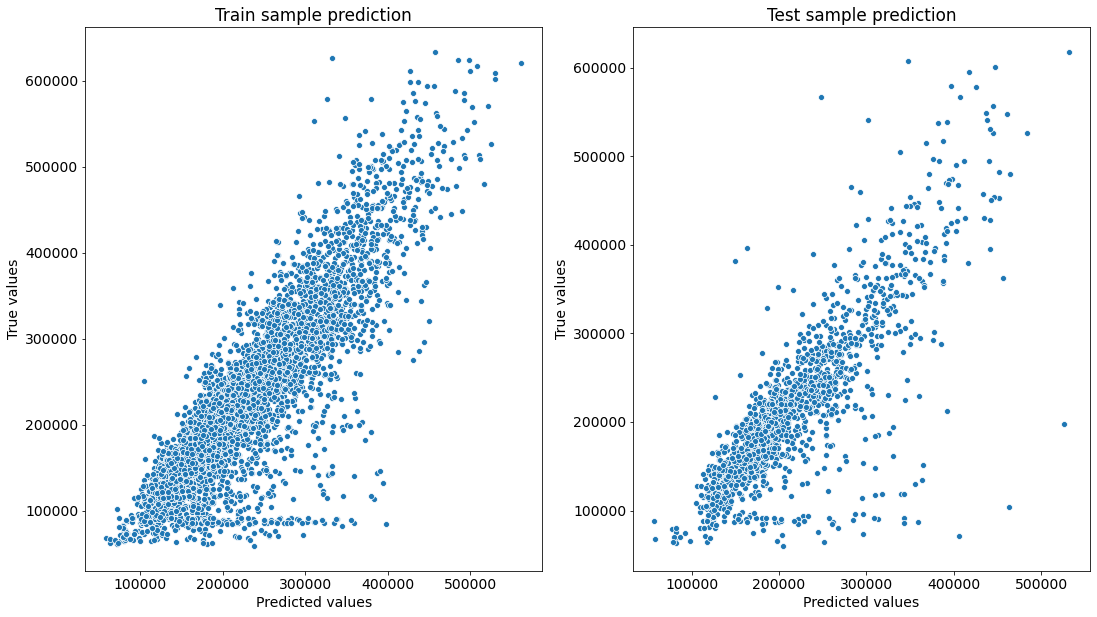

In [41]:
y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_test)
evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

**оптимизируем модель**

In [42]:
gb_model = GradientBoostingRegressor(random_state=42)
params = {'n_estimators':[50, 100, 200, 400], 'max_depth':[3, 5, 7, 10]}

In [43]:
gs = GridSearchCV(gb_model, params, scoring='r2', cv=KFold(n_splits=3, random_state=42, shuffle=True), n_jobs=-1)
gs.fit(X, y)

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=GradientBoostingRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10],
                         'n_estimators': [50, 100, 200, 400]},
             scoring='r2')

In [44]:
gs.best_params_

{'max_depth': 5, 'n_estimators': 100}

In [45]:
gs.best_score_

0.7254428293403591

In [46]:
gb_model_opt = GradientBoostingRegressor(n_estimators=200, max_depth=5, random_state=42)
gb_model_opt.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=5, n_estimators=200, random_state=42)

Train R2:	0.894
Test R2:	0.69


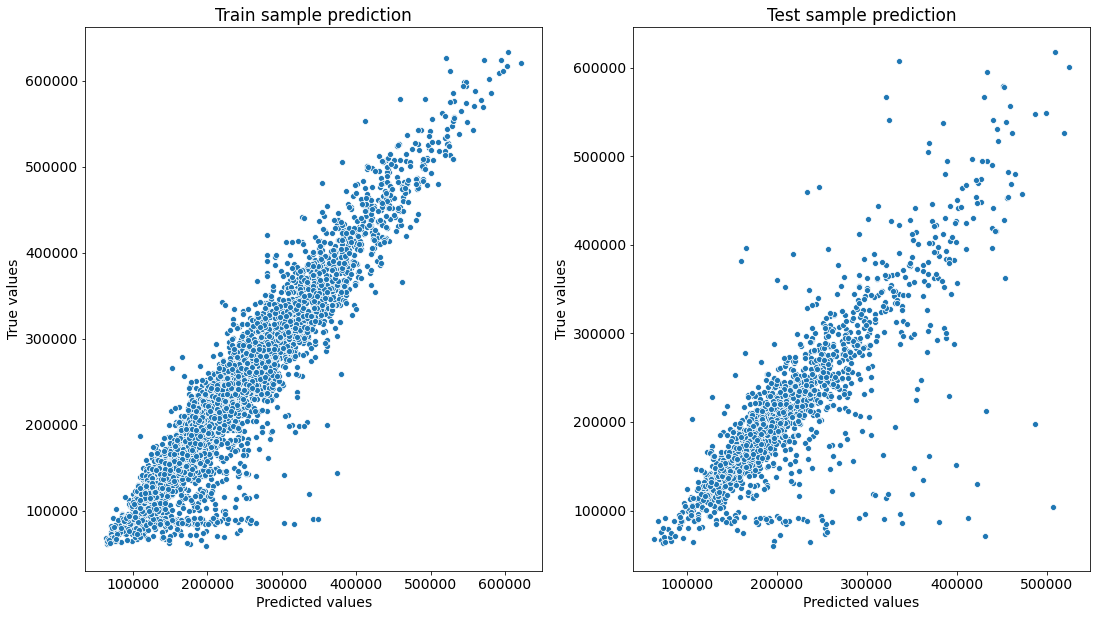

In [47]:
y_train_preds = gb_model_opt.predict(X_train)
y_test_preds = gb_model_opt.predict(X_test)
evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

In [48]:
feature_importances = pd.DataFrame(zip(X_train.columns, gb_model_opt.feature_importances_), columns=['feature_name', 'importance'])
feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.441447
11,Social_2,0.121186
10,Social_1,0.084220
12,Social_3,0.078981
7,Ecology_1,0.045053
0,Rooms,0.044991
6,HouseYear,0.044336
3,KitchenSquare,0.029238
13,Healthcare_1,0.026167
2,LifeSquare,0.025341


In [49]:
y_train_preds = gb_model_opt.predict(X_train)
y_test_preds = gb_model_opt.predict(Xt)

In [50]:
y_test_preds

array([151412.72823358, 196730.31601325, 295641.10109719, ...,
       340939.44794145, 214670.96431106, 177890.34740209])

In [51]:
y_test_preds.shape

(5000,)

In [52]:
test_df['Price'] = y_test_preds

In [53]:
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,Price
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,...,1,900.0,0,0,B,1,1,1,91,151412.728234
1,15856,74,2.0,69.263183,32.925087,1.0,6,1.0,1977,0.075779,...,3,900.0,0,2,B,1,1,1,61,196730.316013
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,...,87,4702.0,5,5,B,1,1,1,2,295641.101097
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,...,3,900.0,3,3,B,1,1,1,49,364929.362813
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,...,1,900.0,0,0,A,1,1,0,391,143401.128607


In [54]:
final_names = ['Id', 'Price']
df_final = test_df[final_names]
df_final

,Id,Price
0,725,151412.728234
1,15856,196730.316013
2,5480,295641.101097
3,15664,364929.362813
4,14275,143401.128607
...,...,...
4995,8180,232389.197700
4996,4695,134296.093093
4997,5783,340939.447941
4998,4780,214670.964311


In [55]:
df_final.to_csv(RESULT_DATASET_EXT_PATH, index=False, encoding='utf-8')

**Визуализация данных**

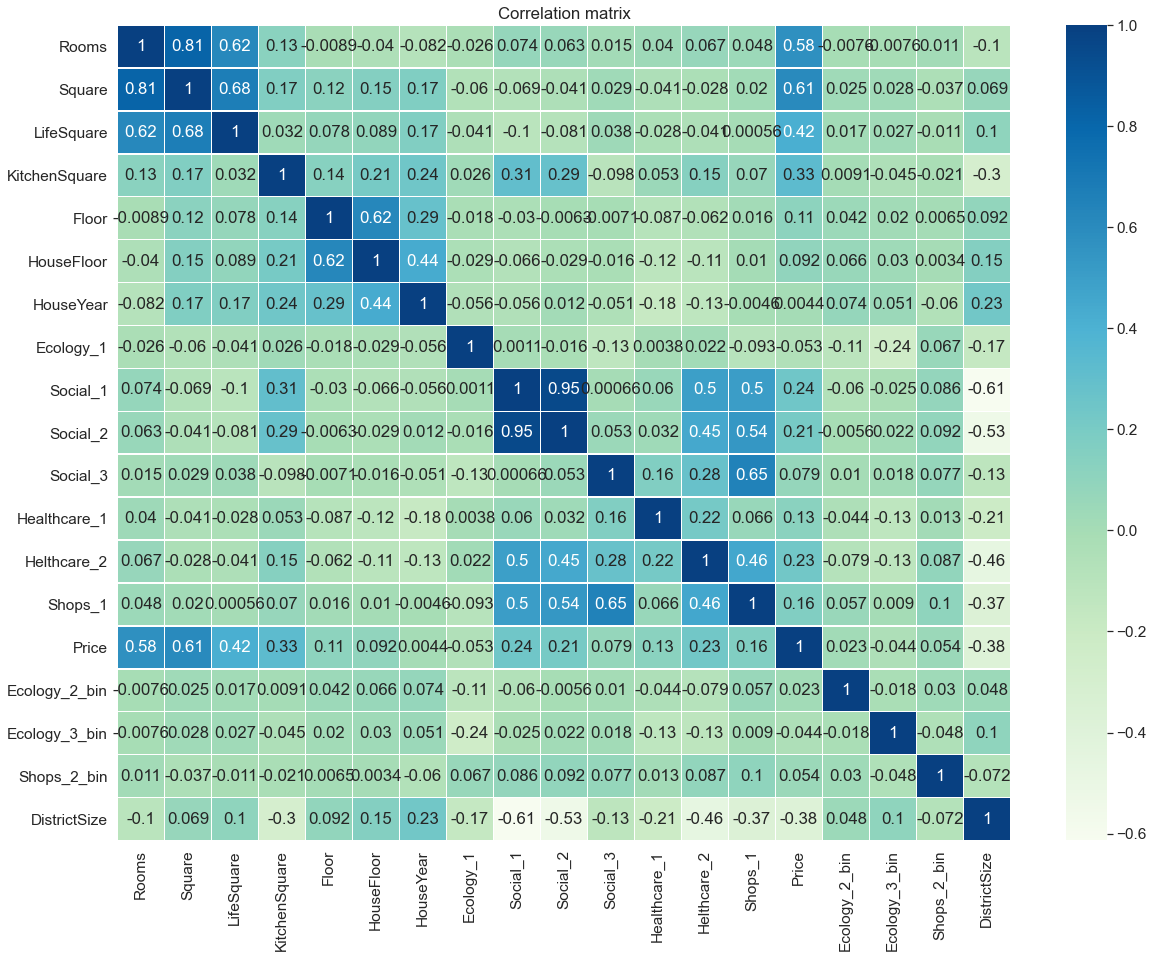

In [56]:
plt.figure(figsize = (20,15))

sns.set(font_scale=1.4)
sns.heatmap(train_df.corr(), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

In [57]:
train_df_num_features = train_df.select_dtypes(include='float64')

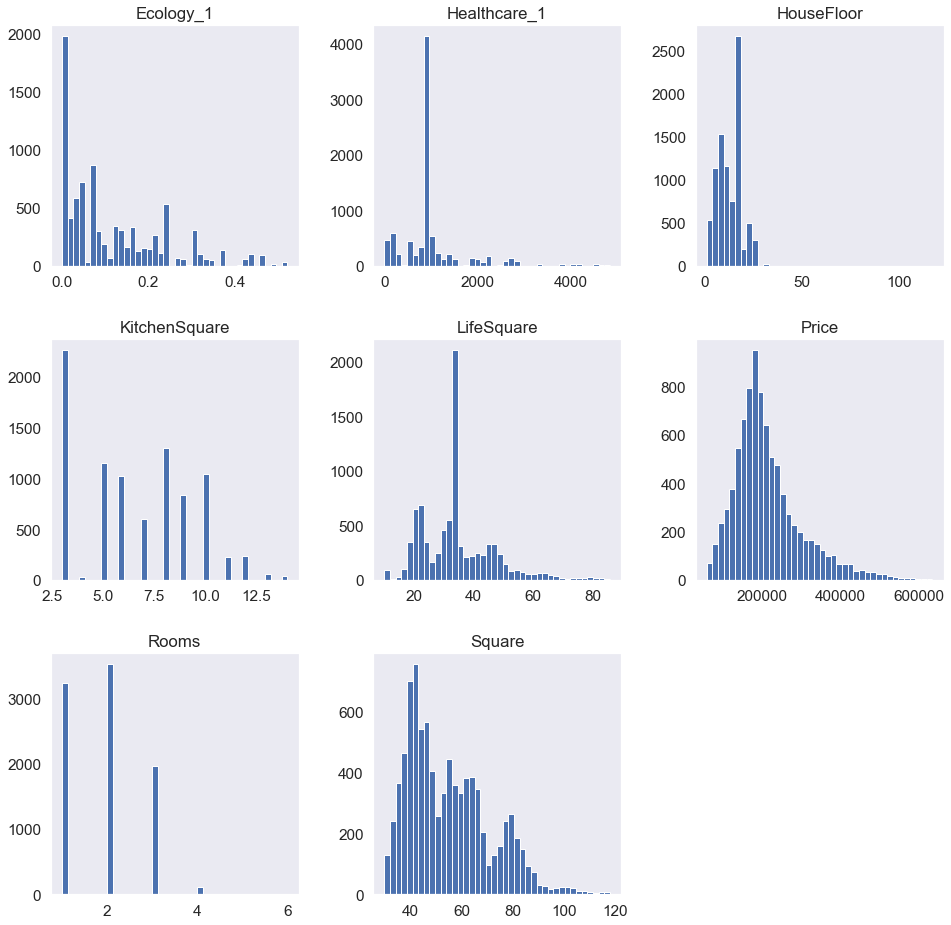

In [58]:
train_df_num_features.hist(figsize=(16,16), bins=40, grid=False);